In [1]:
import polars as pl
import difflib
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np

In [2]:
def plot_time_bargraph(pd_times, pl_times, title, dataframe = False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    if dataframe:
        times = [pd_times, pl_times]
    else:
        pd_averages = np.round([pd_time.average for pd_time in pd_times], 3)
    times = np.round(times, 3)

    sns.barplot(x = ['Pandas', 'Polars'], 
                y = times, palette = "Greens_d",
                width = 0.5
                #color = 'darkseagreen',
                #saturation = 0.75
                )

    ax.set_title(f"Comparison of {title}")
    ax.set_xlabel("Pandas versus Polars")
    ax.set_ylabel("Time (s)")
    
    ax.bar_label(ax.containers[0])
    #plt.savefig(f'./pandas_vs_polars_{title}.png', transparent=False,  facecolor='white', bbox_inches="tight")
    plt.show() 

Polars

In [3]:
# 讀取 CSV 檔案
usecols_df1 = ["station", "sarea"]
pl_df1 = pl.read_csv("Youbike2.0.csv", 
                    encoding = "ANSI",
                    columns = usecols_df1)

In [4]:
usecols = ["rent_station"]
pl_df2 = pl.read_csv("202207_YouBike2.0票證刷卡資料.csv", 
                    encoding = "utf_8_sig",
                    columns = usecols,
                    dtypes = {"rent_station": str})
pl_df2 = pl_df2.head(50000)
print(pl_df2)

shape: (50_000, 1)
┌───────────────────────┐
│ rent_station          │
│ ---                   │
│ str                   │
╞═══════════════════════╡
│ 松山車站              │
│ 莒光大埔街口          │
│ 陽明高中              │
│ 仁愛路四段48巷口      │
│ …                     │
│ 捷運行天宮站(3號出口) │
│ 捷運行天宮站(3號出口) │
│ 捷運行天宮站(3號出口) │
│ 捷運行天宮站(3號出口) │
└───────────────────────┘


In [5]:
# 建立比對函式
def fuzzy_match(a, b):
    # 將字串轉為小寫 if the string is Eng.
    # a = str(a).lower()
    # b = str(b).lower()
    # 使用 difflib 的 SequenceMatcher 計算相似度
    similarity = difflib.SequenceMatcher(None, a, b).ratio()
    return similarity

In [6]:
# 建立 sarea 與 rent_station(sna) 的對應表

sarea_dict = {}
for row in pl_df1.iter_rows(named=True):
    sna = row["station"]
    sarea = row["sarea"]
    sarea_dict[sna] = sarea

print(sarea_dict)

{'捷運科技大樓站': '大安區', '復興南路二段273號前': '大安區', '國北教大實小東側門': '大安區', '和平公園東側': '大安區', '辛亥復興路口西北側': '大安區', '復興南路二段280號前': '大安區', '復興南路二段340巷口': '大安區', '新生南路三段52號前': '大安區', '新生南路三段66號前': '大安區', '新生南路三段82號前': '大安區', '辛亥路一段30號前': '大安區', '和平復興路口西北側': '大安區', '羅斯福路三段311號前': '大安區', '大安運動中心停車場': '大安區', '羅斯福路三段245號前': '大安區', '溫州公園': '大安區', '和平臥龍街口': '大安區', '溫州停車場': '大安區', '銘傳國小側門': '大安區', '捷運公館站(2號出口)': '大安區', '第二學生活動中心': '大安區', '臺灣科技大學正門': '大安區', '臺灣科技大學側門': '大安區', '公館公園': '大安區', '臺灣科技大學後門': '大安區', '臺大醫學院附設癌醫中心': '大安區', '臺大環研大樓': '大安區', '臺大永齡生醫工程館': '大安區', '臺大男七舍前': '大安區', '臺大男一舍前': '大安區', '臺大男六舍前': '大安區', '臺大動物醫院前': '大安區', '臺大土木研究大樓前': '大安區', '臺大萬才館前': '大安區', '臺大國青大樓宿舍前': '大安區', '臺大社科院圖書館前': '大安區', '臺大法人語言訓練中心前': '大安區', '臺大綜合體育館停車場前': '大安區', '辛亥新生路口東南側': '大安區', '基隆長興路口東側': '大安區', '國北教大側門南側': '大安區', '和平實小東北側': '大安區', '大安區健康服務中心': '大安區', '辛亥泰順街口': '大安區', '芳和國中': '大安區', '臥龍樂業街口': '大安區', '臥龍公園': '大安區', '嘉興公園': '大安區', '捷運麟光站(2號出口)': '大安區', '捷運六張犁站': '大安區', '喬治工商': '大安區', '法治公園': '大安區', '捷運臺電大樓站(2號出口)': '大安

In [7]:
# 建立新的欄位 area
# apply() function can make a new column
# 對於每個 rent_station 值，使用 max 函式找出 sarea_dict 中最相似的鍵值(sna)，其中相似度的比較是透過 fuzzy_match 函式進行的。這樣就找到了最相似的 sna 值。
# 再根據 sarea_dict 找到對應的sarea，儲存在新的欄位sarea中

start = time.time()
new_df = pl_df2.with_columns(pl.col("rent_station").apply(lambda x: max(sarea_dict.keys(), key=lambda y: fuzzy_match(x, y))).alias("match_station"))
new_df = new_df.with_columns(pl.col("match_station").apply(lambda x: sarea_dict[x]).alias("sarea"))
new_df.write_csv('202207_YouBike2.0_count.csv', has_header = True)
duration = time.time() - start
print('pandas time:', duration)

pandas time: 1011.5733931064606


In [ ]:
del pl_df1, pl_df2, new_df

Pandas

In [10]:
usecols_df1 = ["station", "sarea"]
df1 = pd.read_csv("Youbike2.0.csv", 
                    encoding = "ANSI",
                    usecols = usecols_df1)


In [11]:
usecols = ["rent_station"]
df2 = pd.read_csv("202207_YouBike2.0票證刷卡資料.csv", 
                    encoding = "utf_8_sig",
                    usecols = usecols,
                    dtype = {"rent_station": str})

df2 = df2.head(50000)

In [12]:
# 建立 sarea 與 rent_station(sna) 的對應表
sarea_dict = {}
for i, row in df1.iterrows():
    sna = row["station"]
    sarea = row["sarea"]
    sarea_dict[sna] = sarea

In [13]:
# 建立新的欄位 area
# apply() function can make a new column
# 對於每個 rent_station 值，使用 max 函式找出 sarea_dict 中最相似的鍵值(sna)，其中相似度的比較是透過 fuzzy_match 函式進行的。這樣就找到了最相似的 sna 值。
# 再根據 sarea_dict 找到對應的sarea，儲存在新的欄位sarea中

start_pd = time.time()
df2["match_station"] = df2["rent_station"].apply(lambda x: max(sarea_dict.keys(), key=lambda y: fuzzy_match(x, y)))
df2["sarea"] = df2["match_station"].apply(lambda x: sarea_dict[x])
df2.to_csv('202207_YouBike2.0_count_pd.csv', index = False, encoding = "utf_8_sig", mode = "a", header=False)
duration_pd = time.time() - start_pd
print('pandas time:', duration_pd)

pandas time: 1311.0877432823181


In [44]:
del df2

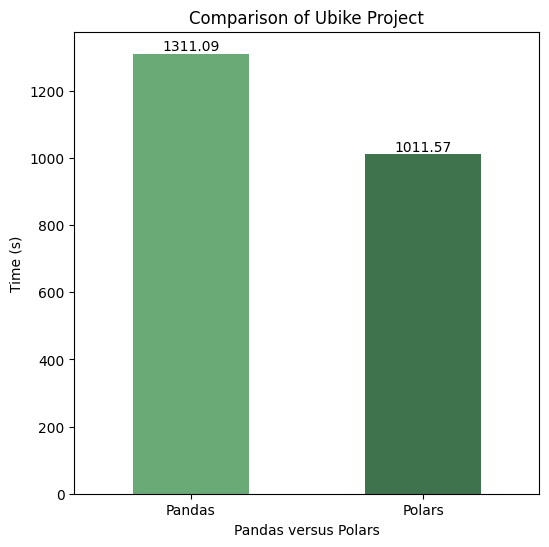

In [14]:
plot_time_bargraph(duration_pd, duration, "Ubike Project", dataframe = True)